# Image Super-Resolution using Bayesian Methods
Course Project for *CS 736: Medical Image Computing*, Spring 2021  
Authors: Harshit Varma and Gaurav P

## Usage: 
Modify the variables (especially `PATH_IMG` and `PRIOR2`) present in the `'Constants'` section accordingly, and run the notebook cell by cell for testing. All results will be saved in the notebook's `'Files'` section, from where they can be downloaded.

In [166]:
# Clear all variables set
%reset -f

# Imports

In [167]:
# General
import time
import random
from tqdm.notebook import tqdm

# Image Processing
import cv2
from PIL import Image
from matplotlib import image

# Tensor Processing
import torch
import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Constants/Fixed Values

In [168]:
torch.cuda.empty_cache()

In [169]:
# Reference: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md

SEED = 20

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [170]:
# Connect to a GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == torch.device("cuda"):
    # Empty GPU cache
    torch.cuda.empty_cache()
    # Print the GPU name
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

t = torch.cuda.get_device_properties(0).total_memory
print(f"GPU Capacity: {t / 1e9} GB")

Tesla T4
GPU Capacity: 15.843721216 GB


In [171]:
"""
Specifies which prior to use for estimating the HR image
Takes values in:
"GP" : Use the Gaussian prior
"MRF" : Use the Markov Random Field prior
"TV" : Use the Total Variation prior
"""
PRIOR2 = "TV"

In [172]:
PATH_IMG = "butterfly.png" # Change this accordingly

# Row x Column format is used everywhere

SHAPE_ORIG_HR = [172, 172] # original HR shape
SHAPE_PATCH_HR = [60, 60] # shape of the HR patch

UPSCALE_FACTOR = 4

SHAPE_ORIG_LR = [dim//UPSCALE_FACTOR for dim in SHAPE_ORIG_HR]
SHAPE_PATCH_LR = [dim//UPSCALE_FACTOR for dim in SHAPE_PATCH_HR]

K = 16
SIGMA_AGN = 0.01

# Functions

## General Functions

In [173]:
def relChange(prev, next):
    """ Returns the % relative change """
    return ((prev - next) / prev)

In [174]:
def gpuMem(t):
    """ Outputs the memory occupied in MB on the GPU/CPU by the tensor t """
    mem = t.element_size() * t.nelement() # in bytes
    return mem / 10**6

In [175]:
def load(path):
    """ Reads an image and performs pre-processing """
    img = cv2.imread(path, 0) # Read in grayscale
    img = Image.fromarray(img) # Convert to PIL Image for downsizing
    img = img.resize((SHAPE_HR[1], SHAPE_HR[0]), Image.ANTIALIAS) # OpenCV doesn't have an ANTIALIAS option
    img = np.asarray(img) # Back to NumPy
    img = img.reshape(N, 1) # Unroll
    img = torch.from_numpy(img.copy()).to(DEVICE) # Convert to torch tensor
    img = img.float() # To FloatTensor
    img = scale(img) # Scale values in [-1/2, 1/2] as specified in the paper
    return img

In [176]:
def disp(img, out_path = None):
    """ Displays an image, and saves it to out_path if specified """

    # Convert to NumPy array
    if type(img) == torch.Tensor:
        if img.is_cuda:
            # Shift to CPU from GPU
            img = img.data.cpu().numpy()
        else:
            img = img.numpy()

    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi = 100, bbox_inches = "tight", format = "jpg", pad_inches = 0)

    plt.show()

In [177]:
def scale(img):
    """ Scales the img to [-0.5, 0.5] """
    img_s = (img - torch.min(img)) / (torch.max(img) - torch.min(img)) # scale to [0, 1]
    img_s = img_s - 0.5 # scale to [-0.5, 0.5]
    img_s = img_s.float()
    return img_s

In [178]:
""" Faster logdet for SPD matrices using cholesky decomposition. 4x faster than torch.logdet """
logdetSPD = lambda X : 2*torch.cholesky(X, upper = False).diagonal(dim1 = -2, dim2 = -1).log().sum(-1)

In [179]:
def getPatch(img, shape, shape_orig, cx, cy):
    """ Get's a shape x shape patch centered at (cx, cy) """
    x_start = cx - shape[0]//2
    x_end   = x_start + shape[0]
    y_start = cy - shape[1]//2
    y_end   = y_start + shape[1]
    patch = img.reshape(shape_orig)
    patch = patch[x_start:x_end, y_start:y_end]
    patch = patch.reshape(-1, 1)
    return patch

In [180]:
def PSNR(x1, x2):
    """ Computes the PSNR between two images """
    x1 = scale(x1)
    x2 = scale(x2)
    mse = torch.mean((x1 - x2) ** 2)
    return 10 * torch.log10(1 / mse)

## Synthesizing LR Images

In [181]:
def positions(shape):
    """ Returns the 2 x N coordinate tensor """
    v = np.indices(shape)
    v = v.reshape(2, -1)
    v = torch.from_numpy(v)
    v = v.float().to(DEVICE)
    return v

In [182]:
def shiftAndRotate(shape, R, s): # involves theta
    """ Returns the u_j^(k)s as defined in the paper """
    u = torch.mm(R, (V_LR - CENTER_HR)) + CENTER_HR + s
    return u

In [183]:
def getRotationMatrix(theta): # involves theta
    """ Returns the 2x2 rotation matrix, theta assumed to be in degrees """
    theta_rad = (np.pi / 180) * theta # To radians
    R = torch.empty(2, 2, dtype = torch.float).to(DEVICE)
    R[0, 0] = torch.cos(theta_rad)
    R[0, 1] = torch.sin(theta_rad)
    R[1, 0] = -torch.sin(theta_rad)
    R[1, 1] = torch.cos(theta_rad)
    # Doing torch.tensor(list, ...) will detach the theta from the CG as list would create copies of the tensors
    return R

The below function is based on the following simplification:
$$
\begin{aligned}
W_{ij} &= \exp \left(\frac{-\|v_j - u_i \|^2}{\gamma^2} \right)\\
&= \exp \left(\frac{2\langle\,u_i,v_j\rangle - \|v_j\|^2 - \|u_i\|^2}{\gamma^2} \right)
\end{aligned}
$$

In [184]:
def transform(s, theta, gamma):
    """ Returns W as defined in the paper by Tipping et al. """

    R = getRotationMatrix(theta)

    # The PSF arra
    u = shiftAndRotate(SHAPE_LR, R, s) # [2, M]

    # W[i, j] = 2*<u[i], v[j]> = 2*(u[i, 1]*v[j, 1] + u[i, 2]*v[j, 2])
    dist_sq = 2*torch.mm(u.t(), V_HR) # [M, 2] x [2, N] = [M, N]
    
    # u2[i] = u[i, 1]^2 + u[i, 2]^2 
    u2 = torch.sum(u**2, axis = 0).reshape(-1, 1) # [M, 1]

    # W[i, j] = -(|| u[i] - v[j] ||^2 / gamma^2)
    dist_sq = (dist_sq - V_HR2 - u2)

    # W[i, j] = exp(-(|| u[i] - v[j] ||^2 / gamma^2)), this takes the most time
    W = torch.exp((1 / (gamma ** 2)) * dist_sq)

    # The normalizing factor (like softmax)
    scale = torch.sum(W, dim = 1).reshape(-1, 1) # [M, 1]

    # W[i, j] = exp(-(|| u[i] - v[j] ||^2 / gamma^2)) / sum_j (exp(-(|| u[i] - v[j] ||^2 / gamma^2)))
    W = W / scale

    return W

In [185]:
def synthLRSingle(img, sigma, s = None, theta = None, gamma = None):
    """ Returns the LR image as a numpy array"""

    # Shift + Rotate + PSF
    if s == None and theta == None and gamma == None:
        sx = random.uniform(-2, 2) / 3 # Since we are using 1/3 image dims compared to the paper
        sy = random.uniform(-2, 2) / 3
        s  = torch.tensor([sx, sy], dtype = torch.float).reshape(2, 1).to(DEVICE)
        theta = torch.tensor(random.uniform(-4, 4)).to(DEVICE) / 3 # Rotation value in degrees
        gamma = 2

    W_k = transform(s, theta, gamma)

    # Additive Gaussian Noise
    eps = sigma * torch.randn(M, 1).to(DEVICE) # ~ N(0, sigma^2), sigma^2 = 1/beta in the paper

    img_lr = torch.mm(W_k, img) + eps

    img_lr = scale(img_lr)

    return img_lr

In [186]:
def getRandomShifts(a, b):
    """ Returns a Kx2x1 tensor randomly initialized using values between a and b """
    s = (b - a)*np.random.rand(K, 2, 1) + a
    s = s.tolist()
    s = [torch.tensor(s_i, dtype = torch.float).to(DEVICE) for s_i in s]
    return s

In [187]:
def getRandomAngles(a, b):
    """ Returns a Kx1 tensor randomly initialized using values between a and b """
    theta = (b - a)*np.random.rand(K, 1) + a
    theta = theta.tolist()
    theta = [torch.tensor(theta_i, dtype = torch.float).to(DEVICE) for theta_i in theta]
    return theta

In [188]:
def synthLRMultiple(img, sigma, s_list = None, theta_list = None, gamma = None):
    """ Returns a list of K LR images and the list of shifts, angles used for creating them """

    if s_list == None and theta_list == None and gamma == None:
        s_list = getRandomShifts(-0.65, 0.65) # ~2/3
        theta_list = getRandomAngles(-1.35, 1.35) # ~4/3
        gamma = 2

    y = [synthLRSingle(img, sigma, s_list[k], theta_list[k], gamma) for k in range(K)]

    return y, s_list, theta_list

## Prior

### Gaussian Prior

In [189]:
# Prior Parameters
PRIOR_STRENGTH = 0.04
CORR_LEN_SCALE = 1

In [190]:
def priorCovariance(A = PRIOR_STRENGTH, r = CORR_LEN_SCALE):
    """ Returns the NxN prior covariance matrix Z_x as specified in the paper """

    dist_sq = 2*torch.mm(V_HR.t(), V_HR) - V_HR2.reshape(1, -1) - V_HR2.reshape(-1, 1)

    global Zx
    Zx = A * torch.exp((1 / r ** 2) * dist_sq)

In [191]:
def logPriorGaussian(x):
    """ Returns the log prior """
    term1 = N * logdet_Zx
    term2 = torch.mm(x.t(), Zx_inv)
    term2 = torch.mm(term2, x)
    log_prior = -0.5 * (term1 + term2)
    return log_prior

### MRF Prior

In [192]:
# Likelihood weight and the huber penalty hyperparameters
BETA = 0.005
HUBER_GAMMA = 0.055

In [193]:
def huber(d, h):
    """ The standard huber penalty """
    abs_d  = torch.abs(d)
    mask_1 = abs_d <= h
    mask_2 = abs_d > h 
    penalty = torch.zeros(d.size(), dtype = torch.float).to(DEVICE)
    penalty[mask_1] = 0.5 * (abs_d[mask_1] ** 2)
    penalty[mask_2] = (h * abs_d[mask_2]) - 0.5*(h**2)
    return penalty

In [194]:
def neighbours(x):
    """ Computes the pixel-neighbour differences using a 4-neighbourhood system """

    x_2d = x.reshape(SHAPE_HR)

    x_t = torch.roll(x_2d, 1, 0)
    x_b = torch.roll(x_2d, -1, 0)
    x_l = torch.roll(x_2d, 1, 1)
    x_r = torch.roll(x_2d, -1, 1)
    
    d_t = x_2d - x_t
    d_b = x_2d - x_b
    d_l = x_2d - x_l
    d_r = x_2d - x_r

    return d_t, d_b, d_l, d_r

In [195]:
def logPriorMRF(x):
    """ Returns the log prior """
    d_t, d_b, d_l, d_r = neighbours(x)
    log_prior = -0.5 * torch.sum(huber(d_t, HUBER_GAMMA) + huber(d_b, HUBER_GAMMA) + huber(d_l, HUBER_GAMMA) + huber(d_r, HUBER_GAMMA))
    return log_prior

### TV Prior

In [196]:
TV_ALPHA = 15

In [197]:
def logPriorTV(x):
    """ Returns the log prior """
    
    x_2d = x.reshape(SHAPE_HR)

    x_t = torch.roll(x_2d, 1, 0)
    x_l = torch.roll(x_2d, 1, 1)
    
    d_t = x_2d - x_t
    d_l = x_2d - x_l
    
    log_prior = -TV_ALPHA * (torch.sum(torch.sqrt(d_t**2 + d_l**2)))

    return log_prior

## Likelihood

In [198]:
def likelihoodMean(y, W):
    """ Returns the mean of the resultant Gaussian formed by the likelihood """

    term1 = torch.zeros(N, N, dtype = torch.float).to(DEVICE)
    term2 = torch.zeros(N, 1, dtype = torch.float).to(DEVICE)

    for k in range(K):
        term1 = term1 + torch.mm(W[k].t(), W[k])
        term2 = term2 + torch.mm(W[k].t(), y[k])

    mu_likelihood = torch.mm(torch.inverse(term1), term2)

    return mu_likelihood

In [199]:
def logLikelihood(x, y, W, sigma):
    """ Returns the log likelihood """

    term1 = (2*K*M) * np.log(sigma)
    
    term2 = torch.tensor(0, dtype = torch.float).to(DEVICE)
    for k in range(K):
        Wx = torch.mm(W[k], x)
        term2 = term2 + torch.sum((y[k] - Wx)**2)
    term2 = (1 / (sigma**2)) * term2

    log_likelihood = -0.5 * (term1 + term2)
    
    return log_likelihood

## Posterior

### Using Gaussian Prior:

In [200]:
def posteriorCovariance(W, sigma):
    """ Returns the covariance of the Gaussian formed by the posterior """
    
    temp = torch.zeros(N, N, dtype = torch.float).to(DEVICE)
    for k in range(K):
        temp += torch.mm(W[k].t(), W[k])

    C = torch.inverse(Zx_inv + ((1 / sigma**2) * temp)).float()
    
    return C

In [201]:
def posteriorMean(y, C, W, sigma):
    """ Returns the mean of the Gaussian formed by the posterior """

    temp = torch.zeros(N, 1, dtype = torch.float).to(DEVICE)
    for k in range(K):
        temp += torch.mm(W[k].t(), y[k])

    mu = (1/sigma**2) * torch.mm(C, temp)

    return mu

In [202]:
def logPosteriorGaussian(x, y, W, sigma):
    """ Returns the log posterior """
    log_posterior = logPriorGaussian(x) + logLikelihood(x, y, W, sigma)
    return log_posterior

### Using MRF Prior

In [203]:
def logPosteriorMRF(x, y, W, sigma):
    """ Returns the log posterior """
    log_posterior = (1 - BETA)*logPriorMRF(x) + BETA*logLikelihood(x, y, W, sigma)
    return log_posterior

### Using TV Prior

In [204]:
def logPosteriorTV(x, y, W, sigma):
    """ Returns the log posterior """
    log_posterior = logPriorTV(x) + logLikelihood(x, y, W, sigma)
    return log_posterior

## Marginal Log Likelihood

In [205]:
def marginalLogLikelihood(y, W, C, mu, sigma):
    """ Returns the marginal likelihood, using the Gaussian prior """

    term1 = torch.tensor(0, dtype = torch.float).to(DEVICE)
    for k in range(K):
        Wmu = torch.mm(W[k], mu)
        term1 += torch.sum((y[k] - Wmu)**2)
    term1 = (1 / (sigma**2)) * term1

    term2 = torch.mm(Zx_inv, mu)
    term2 = torch.mm(mu.t(), term2)

    mll = -0.5 * (term1 + term2 - logdetSPD(C) + logdet_Zx + 2*K*M*np.log(sigma)) # logdet takes the most time

    return mll

# Main

In [206]:
SHAPE_HR = SHAPE_ORIG_HR
SHAPE_LR = SHAPE_ORIG_LR

N = SHAPE_HR[0] * SHAPE_HR[1]
M = SHAPE_LR[0] * SHAPE_LR[1]

CENTER_HR = [dim//2 for dim in SHAPE_HR]
CENTER_HR = torch.tensor(CENTER_HR, dtype = torch.float).reshape(2, 1).to(DEVICE)

# Pre-compute v_hr for reuse
V_HR  = positions(SHAPE_HR)
V_LR  = UPSCALE_FACTOR * positions(SHAPE_LR)
V_HR2 = torch.sum(V_HR**2, axis = 0).reshape(1, -1) # [1, N]

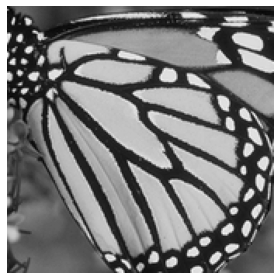

In [207]:
img = load(PATH_IMG)
disp(img.reshape(SHAPE_HR), "hr.jpg")

In [208]:
# Get the list of LR images
y, shifts_true, angles_true = synthLRMultiple(img, SIGMA_AGN)
gamma_true = 2

mkdir: cannot create directory ‘LR’: File exists


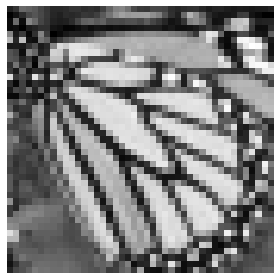

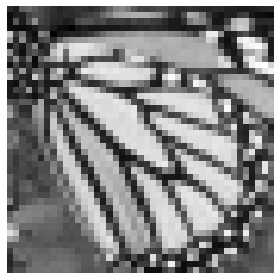

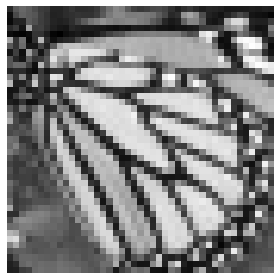

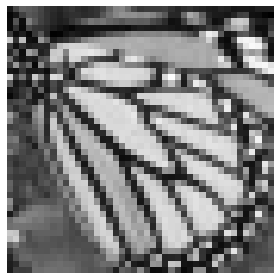

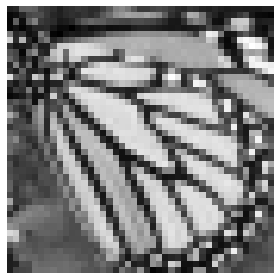

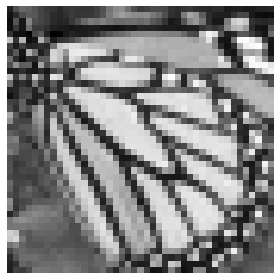

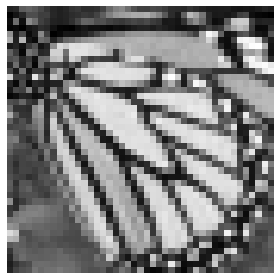

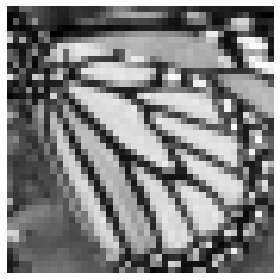

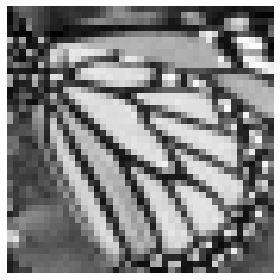

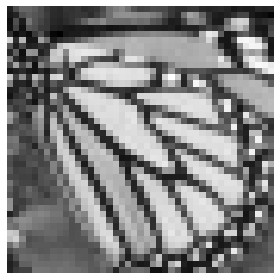

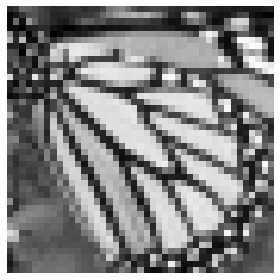

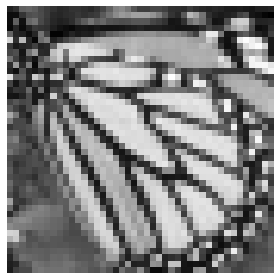

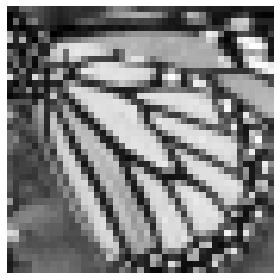

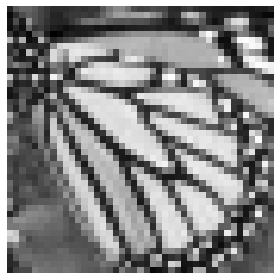

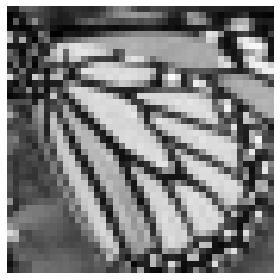

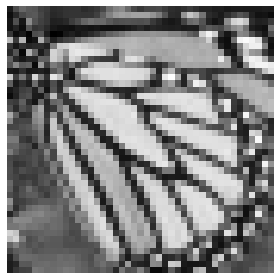

In [209]:
! mkdir LR
for k in range(K):
    disp(y[k].reshape(SHAPE_LR), f"LR/{k+1}.jpg")

In [210]:
! zip -r /content/LR.zip /content/LR

updating: content/LR/ (stored 0%)
updating: content/LR/10.jpg (deflated 4%)
updating: content/LR/6.jpg (deflated 4%)
updating: content/LR/5.jpg (deflated 4%)
updating: content/LR/2.jpg (deflated 4%)
updating: content/LR/4.jpg (deflated 3%)
updating: content/LR/1.jpg (deflated 3%)
updating: content/LR/7.jpg (deflated 4%)
updating: content/LR/11.jpg (deflated 4%)
updating: content/LR/8.jpg (deflated 4%)
updating: content/LR/16.jpg (deflated 4%)
updating: content/LR/9.jpg (deflated 4%)
updating: content/LR/12.jpg (deflated 4%)
updating: content/LR/3.jpg (deflated 4%)
updating: content/LR/14.jpg (deflated 4%)
updating: content/LR/15.jpg (deflated 3%)
updating: content/LR/13.jpg (deflated 4%)


### Crop the Input Images

In [211]:
y_patches = [getPatch(y[k], SHAPE_PATCH_LR, SHAPE_ORIG_LR, SHAPE_ORIG_LR[0]//2, SHAPE_ORIG_LR[1]//2) for k in range(K)]

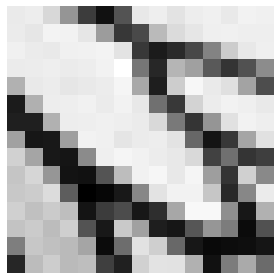

In [212]:
disp(y_patches[0].reshape(SHAPE_PATCH_LR), "patch.jpg")

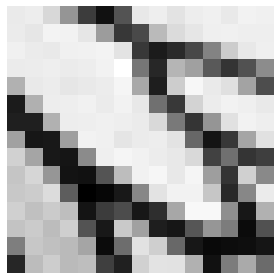

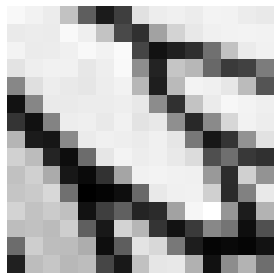

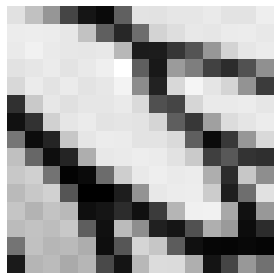

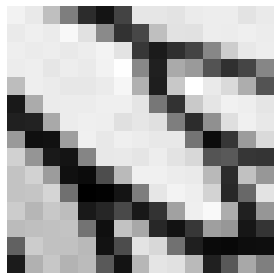

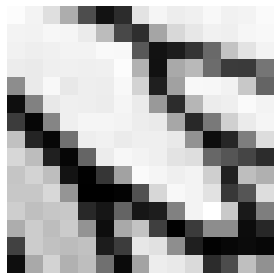

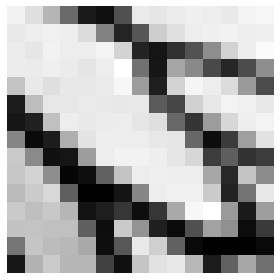

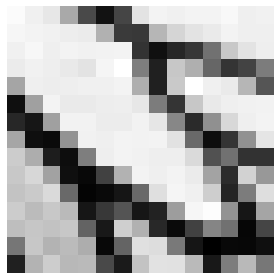

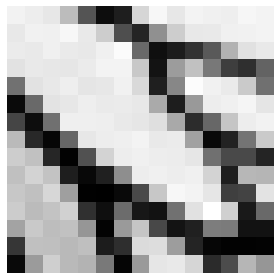

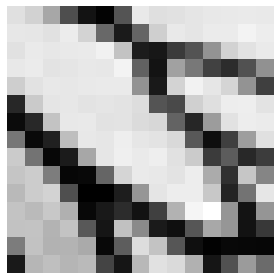

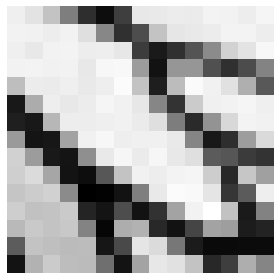

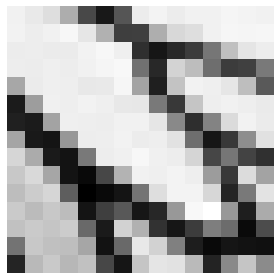

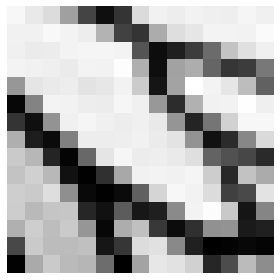

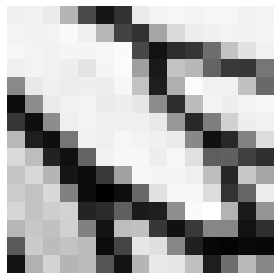

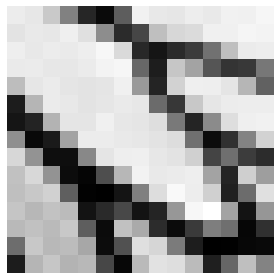

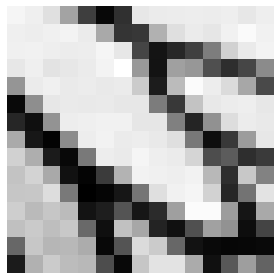

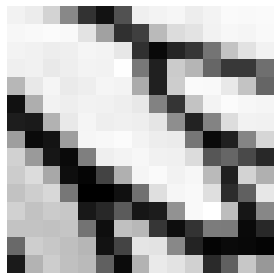

In [213]:
for k in range(K):
    disp(y_patches[k].reshape(SHAPE_PATCH_LR))

In [214]:
torch.cuda.empty_cache()

### Registration Parameters Estimation

In [215]:
SHAPE_HR = SHAPE_PATCH_HR
SHAPE_LR = SHAPE_PATCH_LR

N = SHAPE_HR[0] * SHAPE_HR[1]
M = SHAPE_LR[0] * SHAPE_LR[1]

CENTER_HR = [dim//2 for dim in SHAPE_HR]
CENTER_HR = torch.tensor(CENTER_HR, dtype = torch.float).reshape(2, 1).to(DEVICE)

# Pre-compute v_hr for reuse
V_HR  = positions(SHAPE_HR)
V_LR  = UPSCALE_FACTOR * positions(SHAPE_LR)
V_HR2 = torch.sum(V_HR**2, axis = 0).reshape(1, -1) # [1, N]

In [216]:
# Zx is constant throughout and thus is made global, thus, precompute Z_x, Z_x^{-1} and log(|Z_x)
Zx = torch.empty(N, N, dtype = torch.float).to(DEVICE)
priorCovariance() # Populates Zx
Zx_inv = torch.inverse(Zx)
logdet_Zx = logdetSPD(Zx)

# We don't need Zx anymore
del Zx
torch.cuda.empty_cache() # after this, a total of 2.03 GB is occupied

#### Optimize

In [217]:
shifts = np.zeros((K, 2, 1)) # [K, 2, 1]
shifts = shifts.tolist()
shifts = [torch.tensor(s, dtype = torch.float).to(DEVICE) for s in shifts]

In [218]:
angles = np.zeros((K, 1))
angles = angles.tolist()
angles = [torch.tensor(theta, dtype = torch.float).to(DEVICE) for theta in angles]

In [219]:
gamma = torch.tensor(UPSCALE_FACTOR, dtype = torch.float).to(DEVICE)
gamma.requires_grad  = True

In [220]:
params = [gamma]

for k in range(K):

    shifts[k].requires_grad = True
    params.append(shifts[k])

    angles[k].requires_grad = True
    params.append(angles[k])

In [221]:
N_EPOCH_MAX = 60
N_EPOCH_MIN = 60
EPS_CONVERGENCE = 1e-8
LR = 0.05 # 0.005 -> slower convergence, 0.5 -> everything goes wrong

optimizer = torch.optim.AdamW(
    params,
    lr = LR
)

In [222]:
losses = []
for i in tqdm(range(N_EPOCH_MAX)):

    optimizer.zero_grad()
    
    W = [transform(shifts[k], angles[k], gamma) for k in range(K)]
    C  = posteriorCovariance(W, SIGMA_AGN)
    mu = posteriorMean(y_patches, C, W, SIGMA_AGN)

    torch.cuda.empty_cache()

    loss = -1*marginalLogLikelihood(y_patches, W, C, mu, SIGMA_AGN)
    loss.backward()

    torch.cuda.empty_cache()

    if i > N_EPOCH_MIN:
        rel_change = relChange(losses[-1], loss.item())
        if rel_change < EPS_CONVERGENCE:
            print(f"Convergence reached, relative change in the last iteration: {rel_change}")
            break

    optimizer.step()

    loss_scalar = loss.item()
    losses.append(loss_scalar)
    print(f"Loss: {loss_scalar:.4f}") 

    torch.cuda.empty_cache()

Loss: 23909.5078
Loss: 17806.3477
Loss: 12764.3301
Loss: 8628.8574
Loss: 5301.8496
Loss: 2718.5137
Loss: 780.9805
Loss: -631.0195
Loss: -1639.8906
Loss: -2364.0918
Loss: -2907.3223
Loss: -3345.8965
Loss: -3727.1797
Loss: -4077.4844
Loss: -4411.4707
Loss: -4738.7168
Loss: -5065.9707
Loss: -5396.1621
Loss: -5727.9375
Loss: -6057.0137
Loss: -6378.1309
Loss: -6686.1914
Loss: -6976.6074
Loss: -7245.4512
Loss: -7489.6504
Loss: -7707.8027
Loss: -7899.9727
Loss: -8068.0352
Loss: -8215.2969
Loss: -8345.8262
Loss: -8463.6113
Loss: -8571.4043
Loss: -8670.3711
Loss: -8760.8535
Loss: -8843.6191
Loss: -8919.9746
Loss: -8991.6230
Loss: -9060.0234
Loss: -9126.3340
Loss: -9191.7871
Loss: -9257.2266
Loss: -9322.7344
Loss: -9387.4258
Loss: -9449.6172
Loss: -9507.7637
Loss: -9560.9160
Loss: -9608.7734
Loss: -9651.6816
Loss: -9690.1777
Loss: -9724.9219
Loss: -9756.5527
Loss: -9785.5566
Loss: -9812.4141
Loss: -9837.4688
Loss: -9860.8730
Loss: -9882.7578
Loss: -9903.2129
Loss: -9922.5762
Loss: -9941.1387
Los

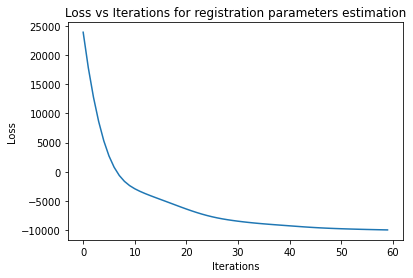

In [223]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for registration parameters estimation")
plt.savefig("loss_reg_estimation.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

In [224]:
for p in params:
    p.requires_grad = False

In [225]:
shifts_list_est_x = []
shifts_list_est_y = []
shifts_list_true_x = []
shifts_list_true_y = []

angles_list_est = []
angles_list_true = []

In [226]:
for k in range(K):

    s_est = shifts[k].data.cpu().numpy()
    s_true = shifts_true[k].data.cpu().numpy()

    print(f"Shifts | True: {s_true} | Estimated: {s_est}")

    shifts_list_est_x.append(s_est[0])
    shifts_list_est_y.append(s_est[1])

    shifts_list_true_x.append(s_true[0])
    shifts_list_true_y.append(s_true[1])

    a_true = angles_true[k].item()
    a_est = angles[k].item()

    print(f"Angles | True: {a_true:.4f} | Estimated: {a_est:.4f}\n")

    angles_list_est.append(a_est)
    angles_list_true.append(a_true)

print(f"Gamma | True Gamma: {gamma_true} | Estimated: {gamma:.4f}")

Shifts | True: [[0.11457004]
 [0.51702785]] | Estimated: [[0.13993536]
 [0.57081205]]
Angles | True: -0.6243 | Estimated: -0.3997

Shifts | True: [[0.50898993]
 [0.4105887 ]] | Estimated: [[0.6157957 ]
 [0.49365342]]
Angles | True: -1.1682 | Estimated: -0.9559

Shifts | True: [[-0.60334355]
 [ 0.24928486]] | Estimated: [[-0.60107183]
 [ 0.2545107 ]]
Angles | True: 0.7329 | Estimated: 0.9592

Shifts | True: [[-0.15771477]
 [ 0.02406423]] | Estimated: [[-0.15991385]
 [ 0.00637429]]
Angles | True: -0.0513 | Estimated: 0.1824

Shifts | True: [[ 0.2053369 ]
 [-0.39799473]] | Estimated: [[ 0.30168083]
 [-0.3575755 ]]
Angles | True: -0.4611 | Estimated: -0.2113

Shifts | True: [[-0.29598868]
 [ 0.2841877 ]] | Estimated: [[-0.2757548]
 [ 0.3692407]]
Angles | True: 0.0287 | Estimated: 0.3368

Shifts | True: [[0.3679047 ]
 [0.45542592]] | Estimated: [[0.4426886]
 [0.5349697]]
Angles | True: -0.6382 | Estimated: -0.3965

Shifts | True: [[ 0.35781837]
 [-0.6023364 ]] | Estimated: [[ 0.4896947]
 [-

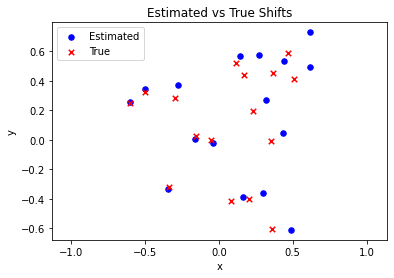

In [227]:
plt.scatter(shifts_list_est_x, shifts_list_est_y, s = 30, c = "b")
plt.scatter(shifts_list_true_x, shifts_list_true_y, s = 30, c = "r", marker = "x")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Estimated vs True Shifts")
plt.legend(["Estimated", "True"])
plt.savefig("estimated_shifts.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

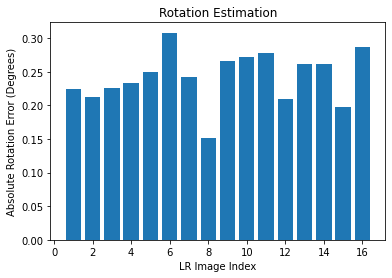

In [228]:
angles_diffs = []
for k in range(K):
    abs_diff = abs(angles_list_est[k] - angles_list_true[k])
    angles_diffs.append(abs_diff)

plt.bar(x = range(1, K+1), height = angles_diffs)
plt.xlabel("LR Image Index")
plt.ylabel("Absolute Rotation Error (Degrees)")
plt.title("Rotation Estimation")
plt.savefig("estimated_angles.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

In [229]:
torch.cuda.empty_cache()

## HR Image Estimation


In [230]:
SHAPE_HR = SHAPE_ORIG_HR
SHAPE_LR = SHAPE_ORIG_LR

N = SHAPE_HR[0] * SHAPE_HR[1]
M = SHAPE_LR[0] * SHAPE_LR[1]

CENTER_HR = [dim//2 for dim in SHAPE_HR]
CENTER_HR = torch.tensor(CENTER_HR, dtype = torch.float).reshape(2, 1).to(DEVICE)

# Pre-compute v_hr for reuse
V_HR  = positions(SHAPE_HR)
V_LR  = UPSCALE_FACTOR * positions(SHAPE_LR)
V_HR2 = torch.sum(V_HR**2, axis = 0).reshape(1, -1) # [1, N]

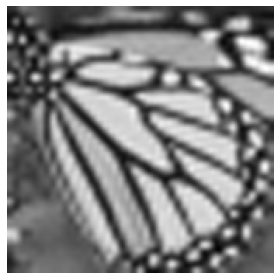

In [231]:
# Initial estimate for the HR image
X = y[0].reshape(SHAPE_LR) # Arbitrarily select the first image
X = X.data.cpu().numpy()
X = cv2.resize(X, (SHAPE_HR[1], SHAPE_HR[0]), interpolation = cv2.INTER_CUBIC)
disp(X, "sr_cubic.jpg")

In [232]:
# No need of these anymore
del Zx_inv
del logdet_Zx
torch.cuda.empty_cache()

In [233]:
if PRIOR2 == "GP":
    # Zx is constant throughout and thus is made global, thus, precompute Z_x, Z_x^{-1} and log(|Z_x)
    Zx = torch.empty(N, N, dtype = torch.float).to(DEVICE)
    priorCovariance() # Populates Zx
    Zx_inv = torch.inverse(Zx)
    logdet_Zx = logdetSPD(Zx)

    # We don't need Zx anymore
    del Zx
    torch.cuda.empty_cache() # after this, a total of 2.03 GB is occupied

In [234]:
X = X.reshape(N, 1)
X = torch.tensor(X, dtype = torch.float).to(DEVICE)
X = scale(X)
X.requires_grad = True

In [235]:
print("Initial PSNR: {:.3f}".format(PSNR(img, X).item()))

Initial PSNR: 15.571


In [236]:
W = [transform(shifts[k], angles[k], gamma) for k in range(K)] # actual MxN Ws, not patches

In [237]:
N_EPOCH_MAX = 100
N_EPOCH_MIN = 100
EPS_CONVERGENCE = 1e-8
LR = 0.05 

optimizer = torch.optim.AdamW(
    [X],
    lr = LR
)

In [238]:
! mkdir GIF

mkdir: cannot create directory ‘GIF’: File exists


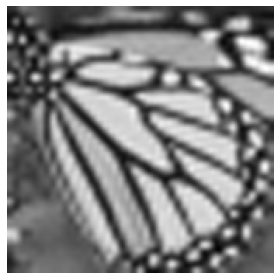

Loss: 1589760.8750
Loss: 903450.6250


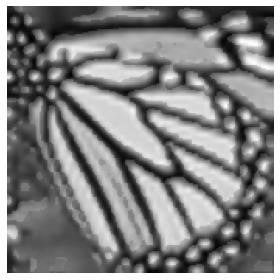

Loss: 505148.9688
Loss: 283921.4688


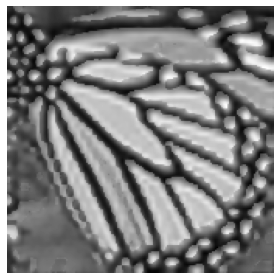

Loss: 181949.5156
Loss: 147655.1094


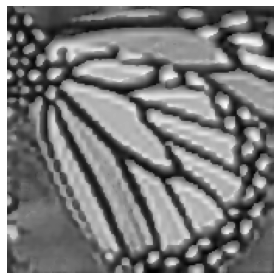

Loss: 144907.9375
Loss: 151974.7812


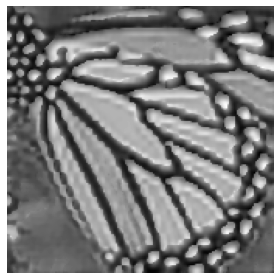

Loss: 156390.4062
Loss: 152458.1719


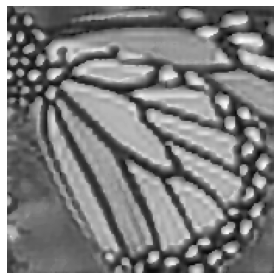

Loss: 140150.7656
Loss: 122734.3125


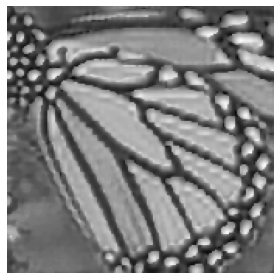

Loss: 103647.4688
Loss: 84842.4141


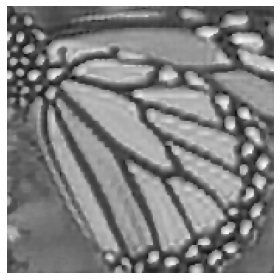

Loss: 66983.9531
Loss: 50612.3906


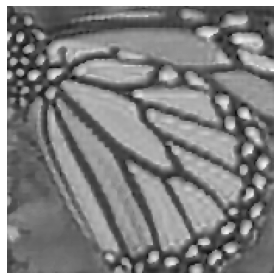

Loss: 36584.2031
Loss: 25545.0312


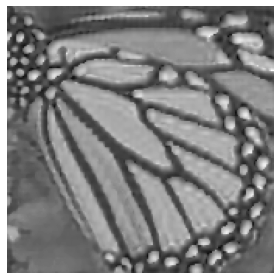

Loss: 17325.7578
Loss: 11146.6055


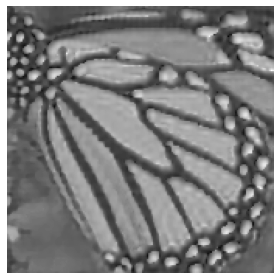

Loss: 6180.6055
Loss: 1913.4844


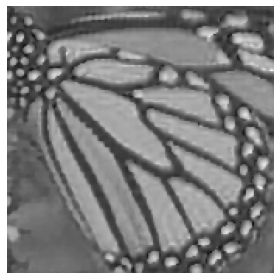

Loss: -1974.6680
Loss: -5783.3594


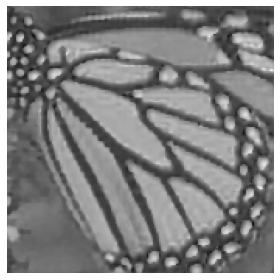

Loss: -9702.1406
Loss: -13725.9805


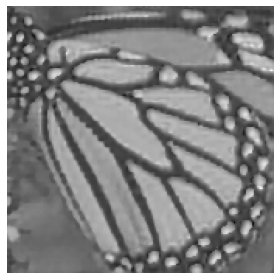

Loss: -17703.0820
Loss: -21534.7031


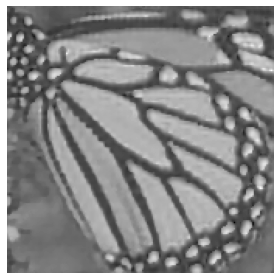

Loss: -25174.2305
Loss: -28509.8125


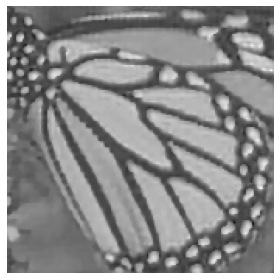

Loss: -31362.4141
Loss: -33635.4688


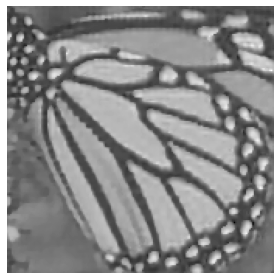

Loss: -35407.7500
Loss: -36858.3906


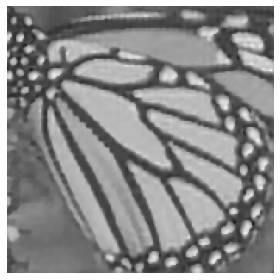

Loss: -38141.0000
Loss: -39338.7852


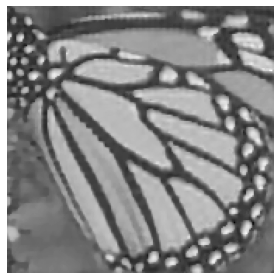

Loss: -40525.4180
Loss: -41754.2656


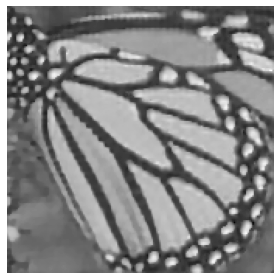

Loss: -43036.5352
Loss: -44303.1875


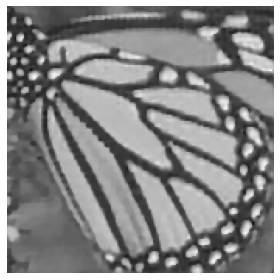

Loss: -45462.7656
Loss: -46474.6641


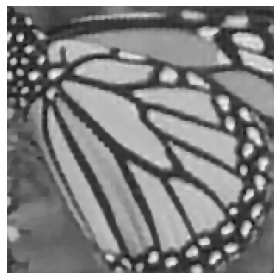

Loss: -47347.4023
Loss: -48121.4102


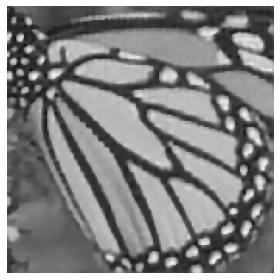

Loss: -48828.0938
Loss: -49478.4023


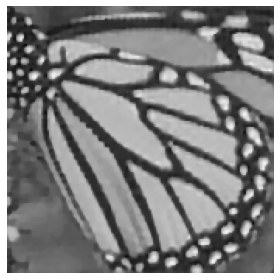

Loss: -50060.6367
Loss: -50572.4453


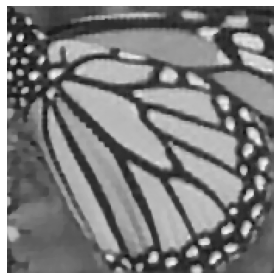

Loss: -51021.3359
Loss: -51432.5352


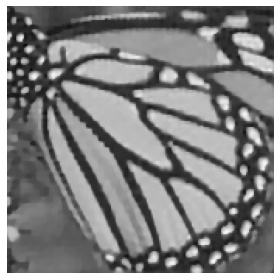

Loss: -51819.1055
Loss: -52183.2734


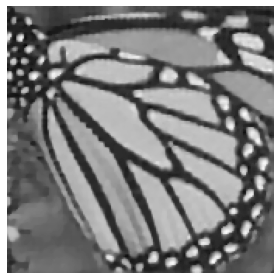

Loss: -52537.0273
Loss: -52891.8555


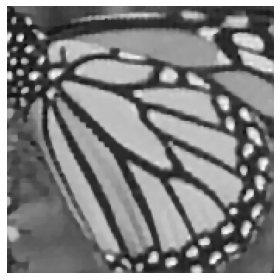

Loss: -53238.0625
Loss: -53557.9922


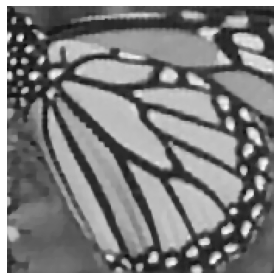

Loss: -53837.5508
Loss: -54074.0547


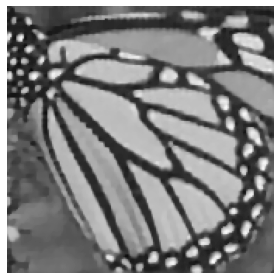

Loss: -54276.6719
Loss: -54461.0078


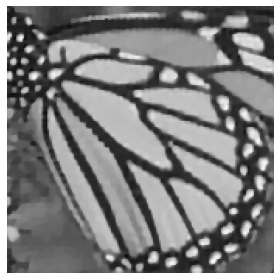

Loss: -54640.6133
Loss: -54817.2734


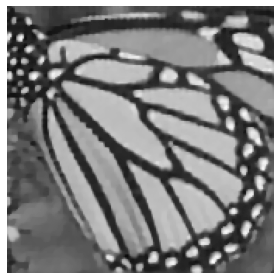

Loss: -54999.2383
Loss: -55174.7148


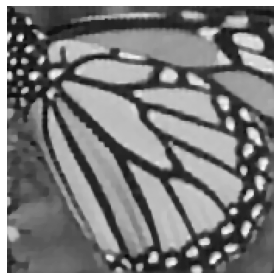

Loss: -55336.4570
Loss: -55476.3164


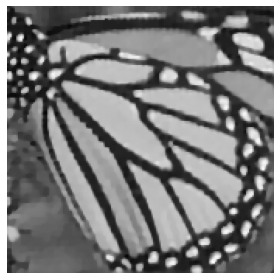

Loss: -55593.2734
Loss: -55701.0352


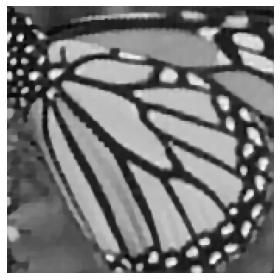

Loss: -55804.5938
Loss: -55903.3906


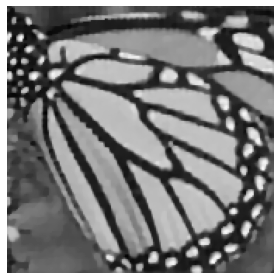

Loss: -55995.8750
Loss: -56087.2109


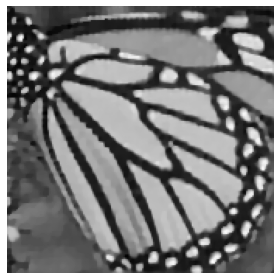

Loss: -56175.0195
Loss: -56263.1758


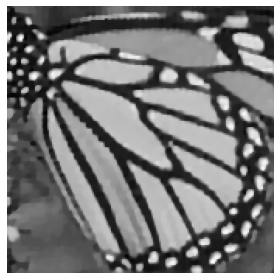

Loss: -56346.3828
Loss: -56423.4648


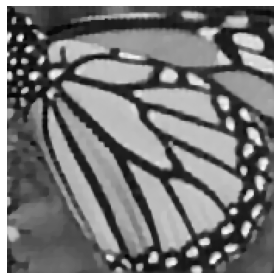

Loss: -56492.7578
Loss: -56553.1641


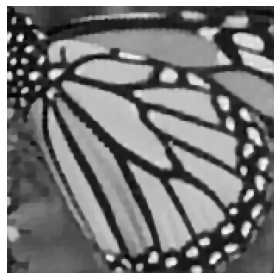

Loss: -56613.9453
Loss: -56666.0781


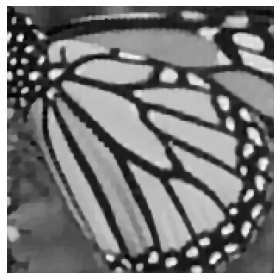

Loss: -56713.5195
Loss: -56767.3984


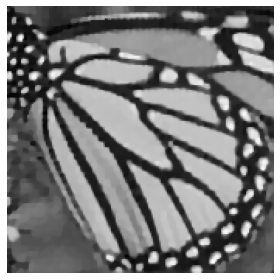

Loss: -56812.5820
Loss: -56857.4141


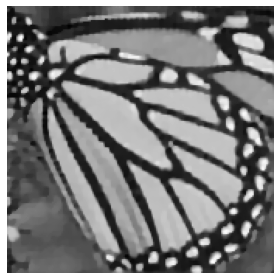

Loss: -56899.3008
Loss: -56939.8047


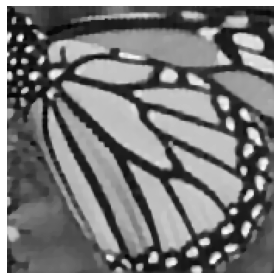

Loss: -56979.3945
Loss: -57016.0859


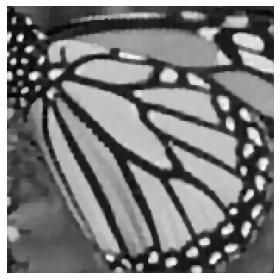

Loss: -57049.8516
Loss: -57080.6445


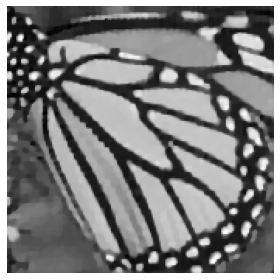

Loss: -57108.6680
Loss: -57140.6680


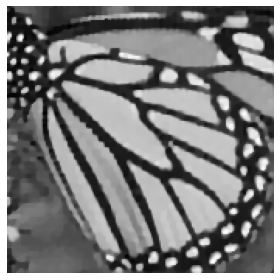

Loss: -57169.5859
Loss: -57198.3828


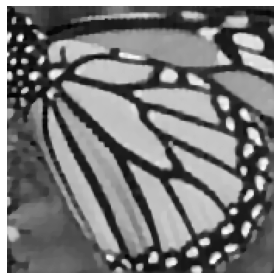

Loss: -57222.8633
Loss: -57245.1641


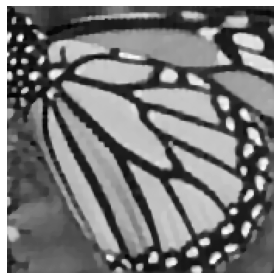

Loss: -57269.4922
Loss: -57293.3477


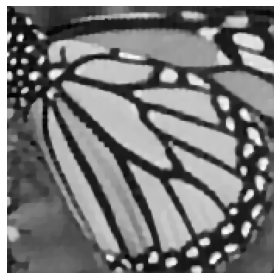

Loss: -57313.7031
Loss: -57334.0312



In [239]:
losses = []
for i in tqdm(range(N_EPOCH_MAX)):

    if i % 2 == 0:
        disp(X.reshape(SHAPE_HR), f"GIF/{i}.jpg")

    optimizer.zero_grad()

    torch.cuda.empty_cache()

    if PRIOR2 == "GP":
        loss = -1*logPosteriorGaussian(X, y, W, SIGMA_AGN)
    elif PRIOR2 == "MRF":
        loss = -1*logPosteriorMRF(X, y, W, SIGMA_AGN)
    else:
        loss = -1*logPosteriorTV(X, y, W, SIGMA_AGN)

    loss.backward()

    torch.cuda.empty_cache()

    if i > N_EPOCH_MIN:
        rel_change = relChange(losses[-1], loss.item())
        if rel_change < EPS_CONVERGENCE:
            print(f"Convergence reached, relative change in the last iteration: {rel_change}")
            break

    optimizer.step()
    
    loss_scalar = loss.item()
    losses.append(loss_scalar)
    print(f"Loss: {loss_scalar:.4f}") 

    torch.cuda.empty_cache()

In [240]:
X.requires_grad = False

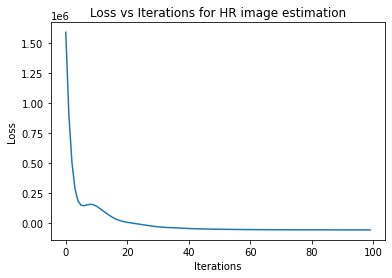

In [241]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for HR image estimation")
plt.savefig("loss_hr_estimation.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

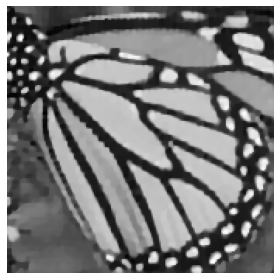

In [242]:
disp(X.reshape(SHAPE_HR), f"sr_{PRIOR2.lower()}_prior.jpg")

In [243]:
print("Final PSNR achieved: {:.3f}".format(PSNR(img, X).item()))

Final PSNR achieved: 22.459


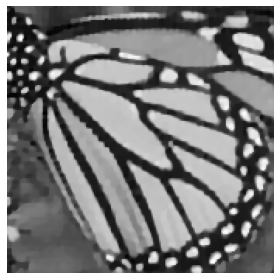

In [244]:
disp(X.reshape(SHAPE_HR), "GIF/100.jpg")

In [245]:
# Create a GIF for visualization

import imageio
images = []

for i in range(0, 100, 2):
    images.append(imageio.imread(f"GIF/{i}.jpg"))

imageio.mimsave("process.gif", images)